In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries.

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

Unzip the dataset stored in your Google Drive.

In [ ]:
!unzip /content/drive/MyDrive/Projects/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/train/0/9687273L.png  
  inflating: archive/train/0/9689906R.png  
 extracting: archive/train/0/9690910L.png  
 extracting: archive/train/0/9690910R.png  
  inflating: archive/train/0/9691359L.png  
  inflating: archive/train/0/9691359R.png  
  inflating: archive/train/0/9692163L.png  
  inflating: archive/train/0/9692604L.png  
  inflating: archive/train/0/9692604R.png  
  inflating: archive/train/0/9692923R.png  
  inflating: archive/train/0/9693364R.png  
  inflating: archive/train/0/9693599L.png  
  inflating: archive/train/0/9693599R.png  
  inflating: archive/train/0/9694101L.png  
  inflating: archive/train/0/9694101R.png  
  inflating: archive/train/0/9695317L.png  
  inflating: archive/train/0/9695317R.png  
  inflating: archive/train/0/9695621L.png  
  inflating: archive/train/0/9695881L.png  
  inflating: archive/train/0/9695881R.png  
  inflating: archive/train/0/9695948L.png  
  inflating: archive/trai

Define paths for training, testing, and validation datasets.

list_of_classes contains the class labels for the dataset.

In [ ]:
train_path = '/content/archive/train'
test_path = '/content/archive/test'
valid_path = '/content/archive/val'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

We have three datasets for training,testing and validation. Finding length of each dataset.Organizing the file paths and labels into DataFrames, enabling efficient data loading and preprocessing for training and evaluation.

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     


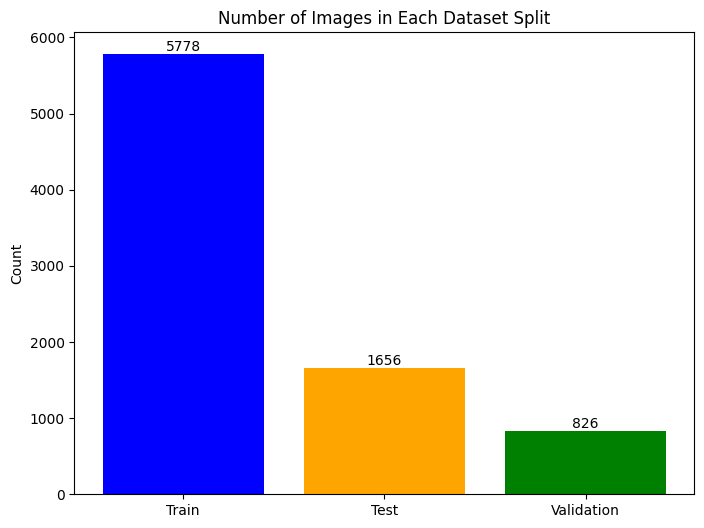

Healthy  has the most images=  2286   Severe  has the least images=  173


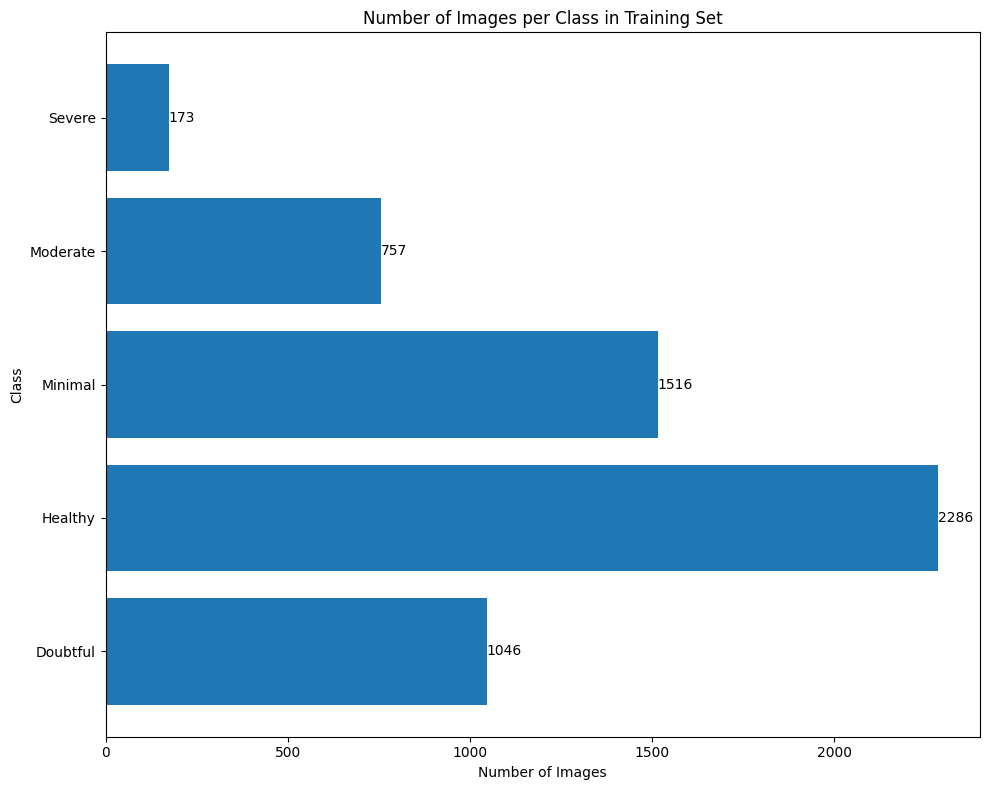

average height=  224  average width=  224 aspect ratio=  1.0


In [ ]:
 for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))



# Visualization for dataset splits
plt.figure(figsize=(8, 6))
split_labels = ['Train', 'Test', 'Validation']
split_counts = [len(train_df), len(test_df), len(valid_df)]
plt.bar(split_labels, split_counts, color=['blue', 'orange', 'green'])
plt.title('Number of Images in Each Dataset Split')
plt.ylabel('Count')
for i, count in enumerate(split_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()


# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

# Visualization for class distribution in training set
plt.figure(figsize=(10, 8))
plt.barh(classlist, countlist)
plt.title('Number of Images per Class in Training Set')
plt.xlabel('Number of Images')
plt.ylabel('Class')
for i, count in enumerate(countlist):
    plt.text(count, i, str(count), va='center')
plt.tight_layout()
plt.show()

# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

The first visualisation show the distribution of images in each dataset split.
The second visualisation shows the distribution of images per class in training dataset.

It is found that training, testing, and validation sets, have 5778, 1656, and 826 images respectively.

The dataset is imbalanced, with the Healthy class having the most images (2286) and the Severe class having the fewest (173), which may bias the model toward the majority class.

 The images have an average height and width of 224pixels with an aspect ratio of 1.0, indicating they are square and suitable for deep learning models requiring fixed input sizes.


As we found that the dataset is imbalanced we are reducing it by limiting the number of samples per class to a specified maximum (max_samples) while ensuring no class falls below a minimum threshold (min_samples).

By setting max_samples=500, the function ensures no class exceeds 500 samples, addressing class imbalance and preventing overrepresentation of majority classes like Healthy.

With min_samples=173, the function retains all samples for minority classes (e.g., Severe), ensuring they are not underrepresented in the trimmed dataset.

We are using random sampling (random_state=123) to maintain fairness and reproducibility when reducing class sizes.

Overall, this step of trimming helps create a more balanced dataset, reducing bias and improving the model's ability to generalize across all classes.

In [ ]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


**Data Augmentation:** The balance function uses techniques like horizontal flipping, rotation, and zooming to generate synthetic images, increasing dataset diversity and addressing class imbalance.

**Target Class Size:** By setting n=500, the function ensures each class reaches 500 samples, boosting minority classes (e.g., Severe) to match the target size.

**Augmentation Process:** For classes with fewer than 500 samples, the function creates additional images (delta = n - sample_count) and saves them in a dedicated directory (aug_dir).

**Dataset Expansion:** The function merges the original dataset with the augmented images, increasing the total dataset size from 2173 to 2500 samples.

**Improved Model Generalization:** Augmentation enhances the dataset's variability, helping the model generalize better and reducing overfitting to minority or majority classes.

In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
          fpath=os.path.join(classpath,f)
          aug_fpaths.append(fpath)
          aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total Augmented images created=  327
Length of augmented dataframe is now  2500


We are combining the classes Healthy, Doubtful, and Minimal into a single class labeled Healthy, simplifying the classification task and reducing complexity.

After relabeling, the dataset now has three classes: Healthy (1500 samples), Moderate (500 samples), and Severe (500 samples), balancing the dataset for better model training.

Hence, Consolidating classes reduces the number of target categories, making the model easier to train and improving its ability to distinguish between the remaining classes.

In [ ]:
def relabel(label_in):
    if label_in =='Healthy' or label_in == 'Doubtful' or label_in =='Minimal':
        label='Healthy'
    else:
        label=label_in
    return label


for df in [train_df, test_df, valid_df]:
    for i in range (len(df)):
        label=df['labels'].iloc[i]
        new_label=relabel(label)
        df['labels'].iloc[i]=new_label
print (train_df['labels'].value_counts())

<ipython-input-8-7d682229a53b>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['labels'].iloc[i]=new_label


labels
Healthy     1500
Moderate     500
Severe       500
Name: count, dtype: int64


We ensure that each class in the dataset has exactly 500 samples, creating a balanced dataset for training and reducing bias toward any particular class.

By setting both max_samples and min_samples to 500, the function guarantees uniformity across all classes, improving the model's ability to generalize and perform equally well on all categories.

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


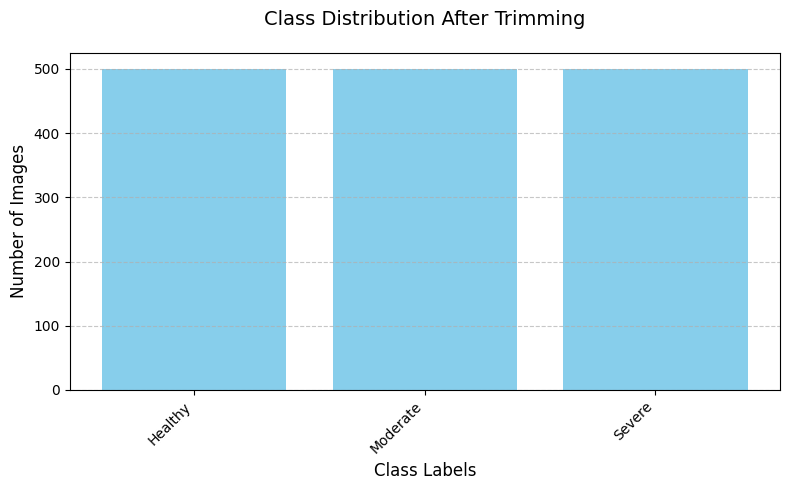

In [ ]:
max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

# Get class counts after trimming
class_counts = train_df['labels'].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Class Distribution After Trimming', fontsize=14, pad=20)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Finding the number of validated images in each datset(training, testing and validation). We should use only the validated images from training and validation datasets.
The visualisation shows that all the classes have same number of images after trimming.


In [ ]:
batch_size=20
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1500 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.
Found 1656 validated image filenames belonging to 3 classes.
test batch size:  72   test steps:  23  number of classes :  3


Display sample batch of images from the data generator, along with their corresponding class labels, to provide a visual understanding of the dataset.


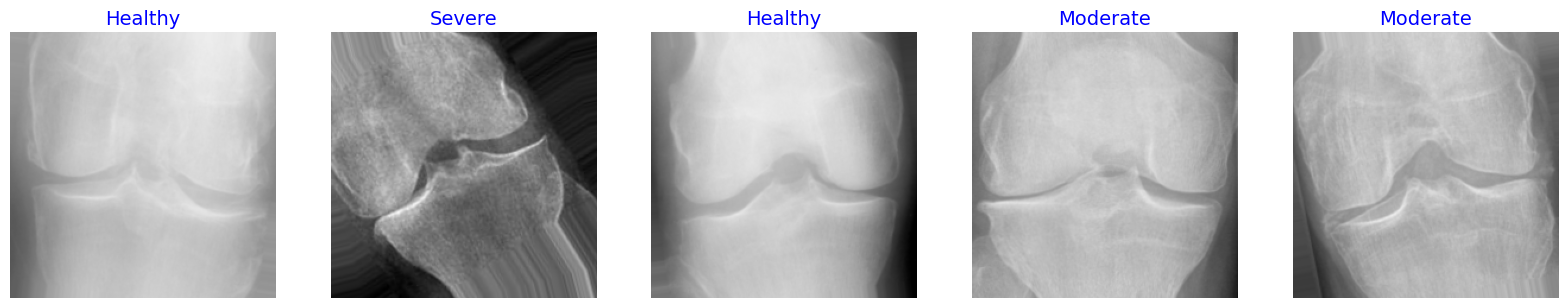

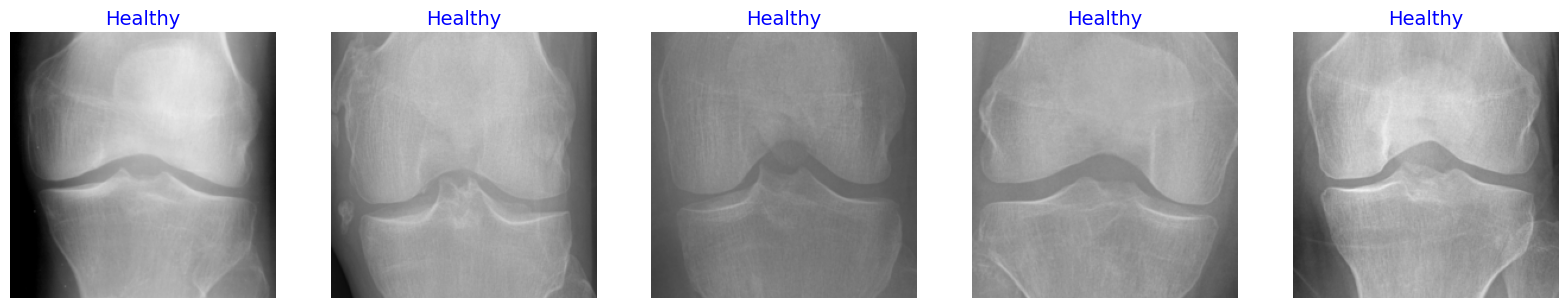

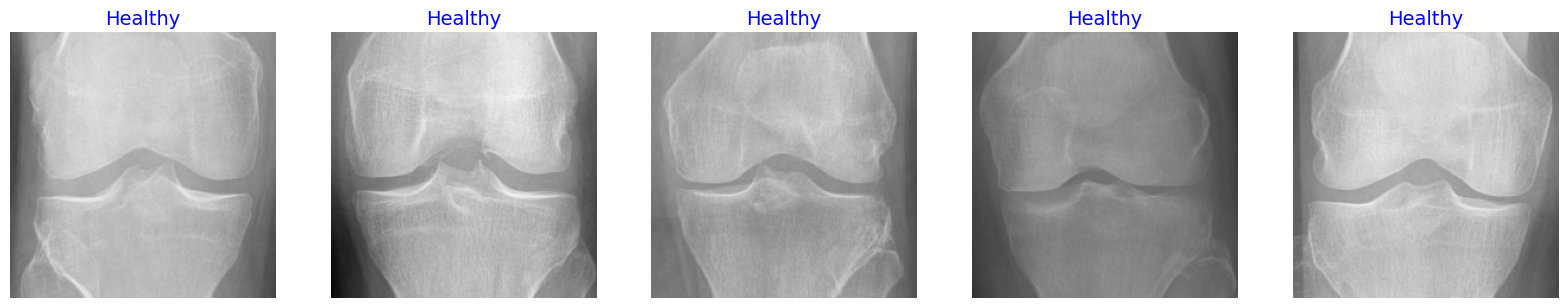

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<5:   #show maximum of 25 images
        r=length
    else:
        r=5
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )
show_image_samples(test_gen )
show_image_samples(valid_gen )

#DenseNet121

DenseNet121:We are using pretrained model- DenseNet121 to get better results compared to our baseline CNN model.The idea behind using DenseNet121 is to capitalize on its ability to efficiently extract rich, high-level features from images.

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Model:**
The core of the model is DenseNet121, a deep convolutional network pre-trained on ImageNet.The base model is set to trainable in this case, allowing the network to fine-tune the pre-trained weights to better fit the target task.
We then added:
*   Global average pooling to reduce the spatial dimensions of the feature maps into a single vector of feature representations.
*   Batch Normalization
*   Two fully connected layers (dense layers) with ReLU activations. These layers allow the model to learn more complex representations based on the features extracted by the DenseNet121 base.
*   We added dropout layers after dense layers to reduce overfitting.
*   And a final output layer which consists of a softmax activation function, which outputs a probability distribution over the 3 classes.

In [ ]:
# Image size
img_size = (224, 224)

# Base model without top
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(img_size[0], img_size[1], 3))
)

# Freeze base model layers (optional: set base_model.trainable=True to fine-tune)
base_model.trainable = True

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(3, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**Compiling the model:**

*   We used Adam Optimizer with a learning rate of 0.001.
*  Loss function - categorical_crossentropy which is ideal for multi-class classification problems.
*  Accuracy is the metric used


In [ ]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

This provides the detailed summary of the model architecture.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,714,371 (29.43 MB)

 Trainable params: 7,628,675 (29.10 MB)

 Non-trainable params: 85,696 (334.75 KB)

We implemented two callbacks for model training in TensorFlow: EarlyStopping and ReduceLROnPlateau.
*   The EarlyStopping callback helps prevent overfitting by stopping the training process early if the model's performance on the validation set does not improve for a specified number of epochs.
*   The ReduceLROnPlateau callback reduces the learning rate when the validation loss plateaus, helping the model converge to a better solution.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [ ]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[early_stop, lr_reduction]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 350ms/step - accuracy: 0.8911 - loss: 0.3015 - val_accuracy: 0.7990 - val_loss: 0.4807 - learning_rate: 6.2500e-05
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 393ms/step - accuracy: 0.8988 - loss: 0.2690 - val_accuracy: 0.4080 - val_loss: 1.0774 - learning_rate: 6.2500e-05
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9170 - loss: 0.2209
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 352ms/step - accuracy: 0.9169 - loss: 0.2210 - val_accuracy: 0.7058 - val_loss: 0.6115 - learning_rate: 6.2500e-05
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 353ms/step - accuracy: 0.9103 - loss: 0.2401 - val_accuracy: 0.5956 - val_loss: 0.7854 - learning_rate: 3.1250e-05
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - accuracy: 0.9232 - loss: 0.2231 - val_accuracy: 0.8801 - val_loss: 0.3045 - learning_rate: 3.1250e-05
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 350ms/step - accuracy:

The model demonstrates consistent improvement in both training and validation accuracy across the epochs.

In the initial epochs, validation performance fluctuates due to a higher learning rate. However, ReduceLROnPlateau successfully reduces the learning rate at key points, helping stabilize learning.

By epoch 13, the model achieves a training accuracy of 93.05% and a validation accuracy of 89.83%, with a validation loss of 0.2812.

The validation accuracy fluctuates slightly between 88.38% to 91.04% in the early epochs but stabilizes by epoch 13, reflecting the effectiveness of learning rate adjustments.

The steady decline in validation loss from 0.4807 (epoch 1) to 0.2812 (epoch 13) shows that the model is converging, indicating successful adaptation and improved generalization.








In [ ]:
#Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.9478 - loss: 0.1250
Test Accuracy: 92.63%


**Test Set Evaluation**

The model achieved the following performance on the test set:

Test Accuracy: 92.63%

Test Loss: 0.1250

This indicates that the model generalizes well to new, unseen data, with a high accuracy rate and relatively low loss.

**Accuracy and Loss Plots**

The following plots show the training and validation accuracy and loss over each epoch. These curves help visualize how well the model is learning and generalizing

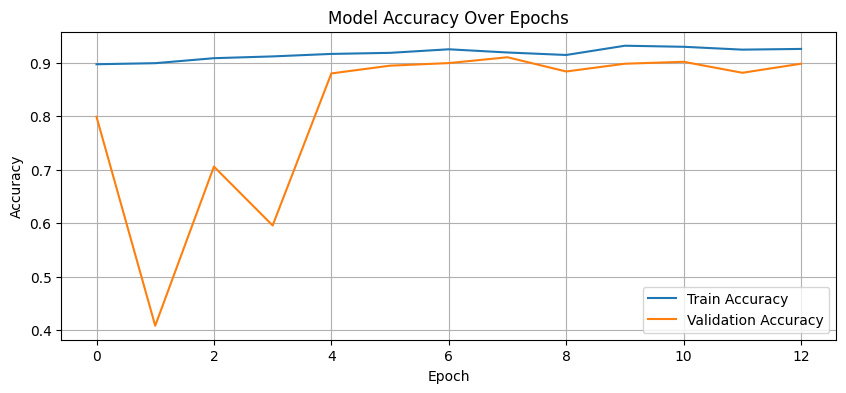

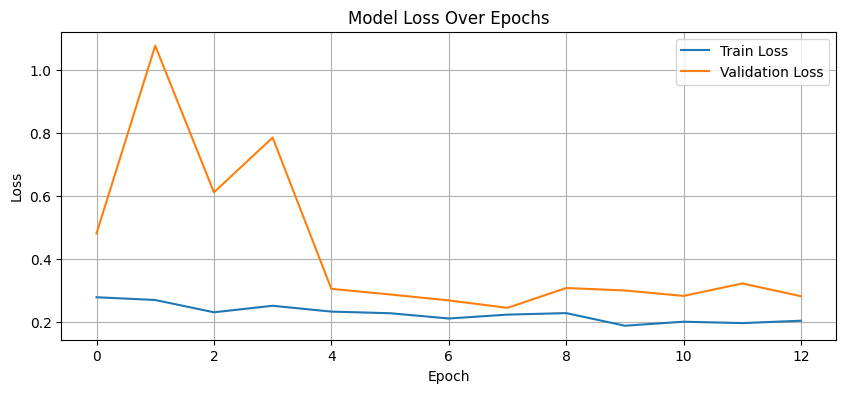

In [ ]:
# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(72, 224, 224, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step
Confusion Matrix


<Axes: >

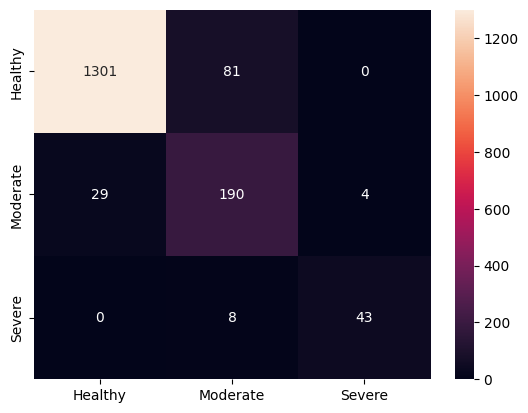

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())

The confusion matrix illustrates how well the model is classifying instances across three categories: Healthy, Moderate, and Severe.

The model performs well in identifying Healthy instances(1301). However, some Moderate instances are misclassified as Healthy (81).

For the Moderate category, the model correctly classifies 190 instances, but there are some misclassifications.

In the Severe category, the model correctly identifies 43 instances, with a few Moderate instances mistakenly classified as Severe (8). There are no misclassifications of Healthy instances as Severe.

Overall, the model is performing well. There are some misclassifications between Moderate and Healthy but fewer errors with Severe. The model shows good generalization and reliable results.


**Classification Report**

This report provides detailed performance metrics- precision,recall,f1-score,support for each class

These metrics help evaluate the model’s effectiveness across all three severity categories. This is especially important in medical classification tasks where identifying Moderate and Severe cases is critical.

In [ ]:
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.98      0.94      0.96      1382
    Moderate       0.68      0.85      0.76       223
      Severe       0.91      0.84      0.88        51

    accuracy                           0.93      1656
   macro avg       0.86      0.88      0.86      1656
weighted avg       0.94      0.93      0.93      1656



**Interpretation:**

The model is performing well with Healthy and Severe classes, showing high precision and recall.

The Moderate class has a lower precision, suggesting the model occasionally misclassifies it, although it has a relatively good recall.

The overall accuracy of 93% is high, but there is chance to improve in handling the Moderate class more precisely.

References

TensorFlow – An End-to-End Open Source Machine Learning Platform - https://www.tensorflow.org/

Keras API Documentation - https://keras.io/api/

DenseNet121- https://keras.io/api/applications/densenet/

Classification Report – scikit-learn - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

Confusion Matrix – scikit-learn - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

ReduceLROnPlateau Callback – Keras - https://keras.io/api/callbacks/reduce_lr_on_plateau/

EarlyStopping Callback – Keras - https://keras.io/api/callbacks/early_stopping/